In [1]:
# Importing (using/include) packages and files needed for the code to run
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics
using Dates
using SpecialFunctions
using Roots
using NLsolve
using Printf
using HDF5
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("GridOperations.jl")
include("Topo.jl")
# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Stefan Problem - test melting and solidification

Step 1 - import packages

Step 2 - Define a function that relates entropy and temperature/pressure. 
$$
T = f_1(P,S)
$$

$$
T = \exp \left( \frac{S}{C_V} + \ln (T_{ref}) - \frac{\Delta H_{fus} }{C_V T_M}X \right)
$$

and 
$$
S = f_2(P,T)
$$
$$
S = C_V (\ln (T) - \ln(T_{ref})) + \frac{\Delta H_{fus}}{T_m}X
$$

In [2]:
# functions that relates entropy and temperature/pressure are define in TemperatureEntropy.jl file
include("TemperatureEntropy.jl")

ghost_nodes_center_TXS (generic function with 1 method)


Step 3 - Write functions to set up the initial condition for the Stefan problem

- Consider a box with width 100 km and height 100 km.
- The box is filled entirely with one material
- Initially, the top 10 km is solid and the bottom 90 km is liquid.
- The sides are insulating
- Density is constant and equal to 1000 kg/m$^3$
- The surface is at T=100K, the bottom is at T=273 K
- The liquid is isothermal with $T=T_m$.
- The solid has initial $T(z)$ given by the Stefan solution (Turcotte and Schubert section 4.18)
$$
\theta = \frac{erf(\eta)}{erf(\lambda_1)}
$$
- Given the initial temperature, compute initial entropy S on the markers.
  

In [3]:
function initial_ice_depth(x::Float64)
    return options["ym"]
end 

struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    function Materials()
        new([0.0],[1e3],[0.0],[2.1e3],[2.2])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    X = markers.scalarFields["X"]
    S = markers.scalarFields["S"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
        markers.scalars[T,i],markers.scalars[X,i] = compute_T_X_from_S((markers.scalars[S,i]),options)
    end
end

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    S = markers.scalarFields["S"]
    X = markers.scalarFields["X"]
    T = markers.scalarFields["T"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    
    # Setting up Stefan conidtion
    lambda1 = get_lambda1(options)
    t = get_t(lambda1,options)
    
    # Note: the melt fraction is defining our layers or ice and water.
    # water - X = 1.0 
    # ice - X = 0.0
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx)
        
        if my > hice # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = 273.0
            markers.scalars[X,i] = 1.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)

        elseif my < hice # icy shell
            markers.integers[material,i] = 1
            markers.scalars[alpha,i] = materials.alpha[1]
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]
            markers.scalars[kThermal,i] = materials.kThermal[1]
            markers.scalars[T,i] = stefan_initial_condition(get_theta(my,t,lambda1),options)
            markers.scalars[X,i] = 0.0
            markers.scalars[S,i] = compute_S_from_T_X(markers.scalars[X,i],markers.scalars[T,i],options)
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

function get_interface(grid::CartesianGrid,mat::Matrix{Float64},contour_value::Float64)
    # Finding interfaces
    interface_position = zeros(Float64,grid.nx+1);
    for j in 1:grid.nx+1
        i = 1
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
            elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + ((grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j]))*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end

get_interface (generic function with 1 method)

# Main part of code
- At each timestep, begin by computing T(S,X) on the markers
- Iteratively solve the temperature equation. Start with a guess S_new = S_old
    - For T_new, compute $q_{cond} = \nabla \cdot (k \nabla T_{new})$
    - Solve diffusion equation for S_new
    - Given S_new, update T_new
    - Iterate until converged...
- Given the new entropy solution on the cell centers, update the entropy and melt fraction on the markers.

In [4]:
function model_run(options::Dict)
    W = 1e4
    H = 2e4
    ny = 50
    nx = Int64(ceil(W/H*ny))
    gx = 0.0
    gy = 0.113
    
    # -1 = insulating, 1 = constant temp 
    Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    # plot interval should be in seconds
    plot_interval = 1e6*seconds_in_year # 1 Myr 
    
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Grid resolution(ny x nx) : $ny x $nx")
    println("Cell size in the x-direction is $(grid.W/(grid.nx-1))")
    println("Cell size in the y-direction is $(grid.H/(grid.ny-1))")
    
    materials = Materials()
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","Cp","Hr","kThermal","S","X"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers,materials,options)

    local time_plot = []
    # local S_contour = []
    local X_contour = []
    local X_contour_array = []
    
    ### Setting up agruments for termination criteria ###
    max_step::Int64=-1
    max_time::Float64=-1
    max_time = max_time == -1.0 ? typemax(Float64) : max_time
    max_step = max_step == -1 ? typemax(Int64) : max_step

    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = dtmax
    
    rho_c = nothing
    kThermal_vx = nothing
    kThermal_vy = nothing
    Hr = nothing
    kThermal = nothing
    dTmax = nothing
    dTemp = nothing
    Tnew = nothing
    Tlast = nothing
    Snew = nothing
    Slast = nothing
    Xnew = nothing
    Xlast = nothing
    q_vx = nothing
    q_vy = nothing
    entropy_contour = nothing
    melt_fraction_contour = nothing
    
    itime = 1 
    terminate = false
    while !terminate
        
        update_marker_prop!(markers,materials)
        rho_c_new,Hr_new,kThermal_new,Slast_new,Xlast_new, = marker_to_stag(markers,grid,["rho","Hr","kThermal","S","X"],"center")
        rhocp = markers.scalars[markers.scalarFields["rho"],:] .* markers.scalars[markers.scalarFields["Cp"],:]
        Tlast_new, = marker_to_stag(markers,grid,["T"],"center",extra_weight = rhocp)
        kThermal_vx_new, = marker_to_stag(markers,grid,["kThermal",],"vx")
        kThermal_vy_new, = marker_to_stag(markers,grid,["kThermal",],"vy")
        
        # deal with any NaN values from interpolation:
        if itime > 1
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(kThermal_vx,kThermal_vx_new)
            replace_nan!(kThermal_vy,kThermal_vy_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(kThermal,kThermal_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(Slast,Slast_new)
            replace_nan!(Xlast,Xlast_new)
        end
        # Copy field data
        rho_c = copy(rho_c_new)
        kThermal_vx = copy(kThermal_vx_new)
        kThermal_vy = copy(kThermal_vy_new)
        Hr = copy(Hr_new)
        kThermal = copy(kThermal_new)
        Tlast = copy(Tlast_new)    
        Slast = copy(Slast_new)
        Xlast = copy(Xlast_new)
        
        Tlast,Xlast = update_T_X_from_S(Slast,options)
        Tlast,Xlast,Slast = ghost_nodes_center_TXS(grid,Tlast,Xlast,Slast,Tbctype,Tbcval,options) 
        
        # Initial guess for S
        Snew = copy(Slast)
        # Initial guess for T
        Tnew,Xnew = update_T_X_from_S(Snew,options)
        Tnew,Xnew,Snew = ghost_nodes_center_TXS(grid,Tnew,Xnew,Slast,Tbctype,Tbcval,options)

        diffusion_timestep = calculate_diffusion_timestep(grid,options)
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        if this_dtmax > diffusion_timestep
            dt = diffusion_timestep
        else 
            dt = this_dtmax
        end

        if itime == 1   
            println("Diffusion timestep is ",diffusion_timestep/seconds_in_year," yr, ",diffusion_timestep/seconds_in_year/1e3," Kyr, ",diffusion_timestep/seconds_in_year/1e6," Myr")
            println("Starting step $itime, with dt = ",dt/seconds_in_year," yr, ",dt/seconds_in_year/1e3," Kyr, ",dt/seconds_in_year/1e6," Myr")
            figure()
            title(L"Initial\,Melt\,Fraction")
            cs = contour(grid.xc/1e3,grid.yc/1e3,Xnew,[0.5],colors="red")
            clabel(cs,inline=true,fontsize=8,fmt="Solidification boundary")
            pcolor(grid.xc/1e3,grid.yc/1e3,Xnew)
            colorbar(cmap="viridis")
            gca().set_ylabel(L"Height\,(km)")
            gca().set_xlabel(L"Width\,(km)")
            gca().invert_yaxis()
            gca().set_aspect("equal")
            tight_layout()
            show() 
        elseif mod(itime,100) == 0
            println("Starting step $itime, with dt = ",dt/seconds_in_year," yr, ",dt/seconds_in_year/1e3," Kyr, ",dt/seconds_in_year/1e6," Myr")
        end

        last_T_norm = NaN
        T_norm = NaN
        dT = nothing
        dTmax = Inf
        dS = nothing
        dSmax = Inf
        tolerance = 1e-8
        dTnorm = []
        ititer = []
        titer = 1 
        max_titer = 300
        for titer=1:max_titer
            
            # println("Starting iteration $titer, with timestep = ",dt/seconds_in_year," yr, ",dt/seconds_in_year/1e3," Kyr, ",dt/seconds_in_year/1e6," Myr")            
            
            # Computing conductive heat flux
            q_vx,q_vy = compute_q_cond(grid,Tnew,kThermal_vx,kThermal_vy) # W/m^2
            
            # Computing the new entropy
            Snew = compute_S_new(grid,Tnew,rho_c,Hr,q_vx,q_vy,Slast,dt);
    
            # Updating the new temperature and new melt fraction from the new entropy
            Tnew,Xnew = update_T_X_from_S(Snew,options)             
            Tnew,Xnew,Snew = ghost_nodes_center_TXS(grid,Tnew,Xnew,Snew,Tbctype,Tbcval,options)
       
            if titer > 1
                last_T_norm = T_norm;
                T_norm = norm(Tnew[2:grid.ny,2:grid.nx]);
                # println("[",titer,"]: Change in norm is :",abs(T_norm-last_T_norm))
                push!(dTnorm,abs(T_norm-last_T_norm))
                push!(ititer,titer)
            else
                # T_norm = norm(Tnew[2:grid.ny,2:grid.nx]);
                T_norm = norm(Tnew[2:end-1,2:end-1]);
                push!(dTnorm,abs(T_norm-last_T_norm))
                push!(ititer,titer)
            end
            
            # Computing the maximum temperature change
            dT = Tnew - Tlast
            dTmax = maximum(abs.(dT[2:grid.ny,2:grid.nx]))
            # println("Maximum temperature change = $dTmax K")

            # Computing the maximum entropy change
            dS = Snew - Slast
            dSmax = maximum(abs.(dS[2:grid.ny,2:grid.nx]))
            # println("Maximum Entropy change = $dSmax J/K")
            
            # # Printing dt
            # println("dt = ",dt/seconds_in_year," yr, ",dt/seconds_in_year/1e3," Kyr, ",dt/seconds_in_year/1e6," Myr")
            # dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)

            # Checking for convergence:
            if titer > 1 && abs(T_norm-last_T_norm) < tolerance
                # println("Converged after $titer iterations.")
                break
            elseif titer == max_titer
                terminate = true
                # error("Did not converged")
                @error("Did not converged")
            elseif any(isnan.(dT))
                terminate = true
                # error("NaN or Inf apperred")
                @error("NaN or Inf apperred")
            end
        end
        
        # Updating entropy on the markers by projecting dS from the cell centers to the markers
        cell_center_change_to_markers!(markers,grid,dS,"S")
        
        # entropy_contour = get_interface(grid,-Snew,-0.0)
        # avg_entropy_contour = mean(entropy_contour)
        # append!(S_contour,avg_entropy_contour)
        
        melt_fraction_contour = get_interface(grid,-Xnew,-0.5)
        append!(X_contour_array,[melt_fraction_contour])
        avg_melt_fraction_contour = mean(melt_fraction_contour)
        append!(X_contour,avg_melt_fraction_contour)
        append!(time_plot,time)  

        # Checking Termination Criteria, time is in Myr, amplitude is in meters
        if time >= max_time || itime >= max_step || (X_contour[itime] - X_contour[1]) > 5e3
            terminate = true
            figure()
            title(L"Melt\,Fraction")
            cs = contour(grid.xc/1e3,grid.yc/1e3,Xnew,[0.5],colors="red")
            clabel(cs,inline=true,fontsize=8,fmt="Solidification boundary")
            pcolor(grid.xc/1e3,grid.yc/1e3,Xnew)
            colorbar(cmap="viridis")
            gca().set_ylabel(L"Height\,(km)")
            gca().set_xlabel(L"Width\,(km)")
            gca().invert_yaxis()
            gca().set_aspect("equal")
            tight_layout()
            show() 
        end

        time += dt
        if mod(itime,100) == 0
            println("Ice shell as thicken by ",(X_contour[itime] - X_contour[1])/1e3,"km")
            println("time = ",time/seconds_in_year," yr, ",time/seconds_in_year/1e3," Kyr, ",time/seconds_in_year/1e6," Myr") 
        end
        itime += 1
    end
    return grid,time_plot,X_contour_array,X_contour,itime
end

model_run (generic function with 1 method)

Grid resolution(ny x nx) : 50 x 25
Cell size in the x-direction is 416.6666666666667
Cell size in the y-direction is 408.16326530612247
Creating Markers...
  0.000969 seconds (19 allocations: 4.750 MiB)
Initial condition...
  2.058818 seconds (5.28 M allocations: 289.287 MiB, 18.49% gc time, 96.17% compilation time)
Diffusion timestep is 504.8401549859274 yr, 0.5048401549859274 Kyr, 0.0005048401549859274 Myr
Starting step 1, with dt = 504.8401549859274 yr, 0.5048401549859274 Kyr, 0.0005048401549859274 Myr


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


Starting step 100, with dt = 504.8401549859274 yr, 0.5048401549859274 Kyr, 0.0005048401549859274 Myr
Ice shell as thicken by 0.15107467439326866km
time = 50484.01549859272 yr, 50.48401549859272 Kyr, 0.05048401549859272 Myr
Starting step 200, with dt = 504.8401549859274 yr, 0.5048401549859274 Kyr, 0.0005048401549859274 Myr
Ice shell as thicken by 0.2368569808689772km
time = 100968.03099718524 yr, 100.96803099718524 Kyr, 0.10096803099718524 Myr
Starting step 300, with dt = 504.8401549859274 yr, 0.5048401549859274 Kyr, 0.0005048401549859274 Myr
Ice shell as thicken by 0.32980351727932067km
time = 151452.04649577776 yr, 151.45204649577775 Kyr, 0.15145204649577776 Myr
Starting step 400, with dt = 504.8401549859274 yr, 0.5048401549859274 Kyr, 0.0005048401549859274 Myr
Ice shell as thicken by 0.5252405923826172km
time = 201936.06199437025 yr, 201.93606199437025 Kyr, 0.20193606199437025 Myr
Starting step 500, with dt = 504.8401549859274 yr, 0.5048401549859274 Kyr, 0.0005048401549859274 Myr
Ice

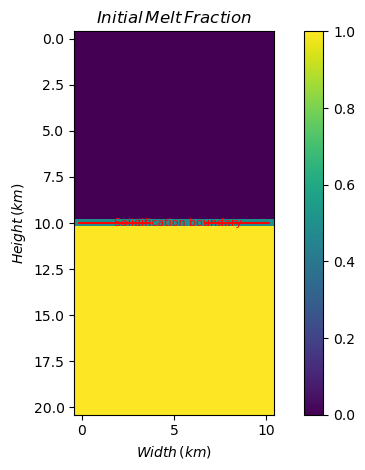

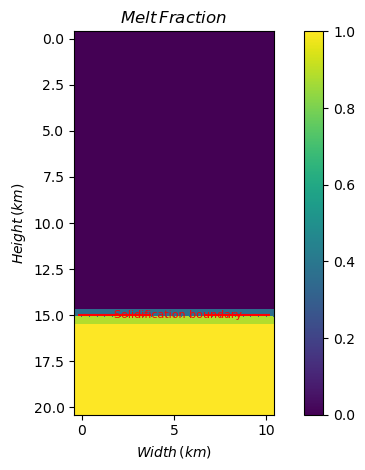

In [5]:
options = Dict()
options["latent heat of fusion"] = 3.34e5 #J/kg
options["specific heat of ice"] = 2.1e3 # J/kg*K (ice)
options["density of ice"] = 1e3 # kg/m^3
options["thermal conductivity of ice"] = 2.2 # W/m*K
options["thermal diffusivity"] = options["thermal conductivity of ice"] / (options["density of ice"]*options["specific heat of ice"]) # m^2/s
options["Tm"] = 273.0 # K
options["To"] = 100.0 # K
options["ym"] = 1e4 # m 
grid,time_plot,X_contour_array,X_contour,itime = model_run(options);

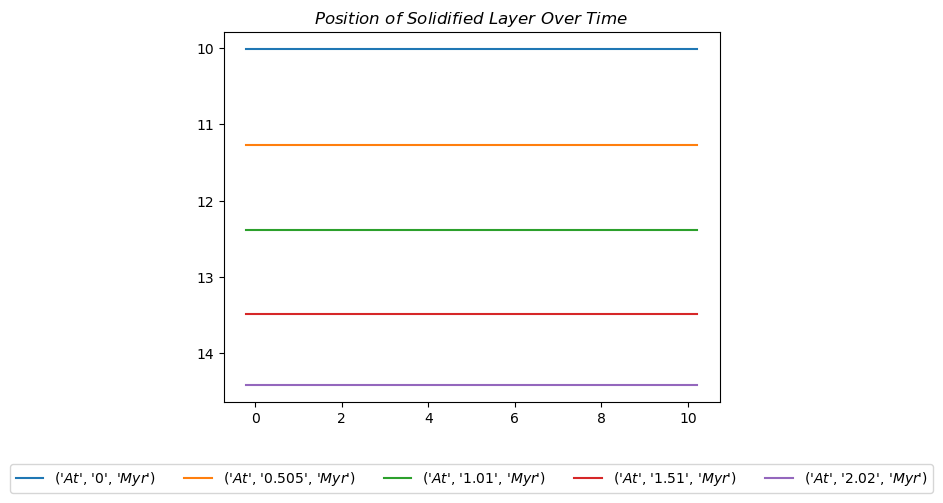

In [7]:
# Profile of ice-water inferface topograpgy over time from melt fraction
figure()
for i in 1:1000:itime-1
    plot(grid.xc/1e3,X_contour_array[i]/1e3,label=(L"At",@sprintf("%.3g",time_plot[i]/3.15e7/1e6),L"Myr"))
end
title(L"Position\,\,of\,\,Solidified\,\,Layer\,\,Over\,\,Time")
gca().invert_yaxis()
# Legend is at the bottom
legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),ncol=5)
show()

In [ ]:
lambda1 = get_lambda1(options)
t = get_t(lambda1,options)
y = get_y.(lambda1,time_plot.+t,Ref(options))
figure()
plot(time_plot/3.15e7/1e6,y/1e3,"b-",label="Stefan Solution")
# plot(time_plot/3.15e7/1e6,S_contour/1e3,"r--",label="Numerical Solution from Entropy contour")
plot(time_plot/3.15e7/1e6,X_contour/1e3,"g--",label="Numerical Solution from Melt Fraction contour")
gca().set_ylabel(L"Ice\,Thickness\,(km)")
gca().set_xlabel(L"Time\,(Myr)")
legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),ncol=5)
show()

In [ ]:
# # # Profile of ice-water inferface topograpgy over time from melt fraction
# figure()
# for i in 1:1:itime-1
#     plot(grid.xc/1e3,X_contour_array[i]/1e3,label=(L"At",@sprintf("%.3g",time_plot[i]/3.15e7/1e6),L"Myr"))
# end
# title(L"Position\,\,of\,\,Solidified\,\,Layer\,\,Over\,\,Time")
# gca().invert_yaxis()
# # Legend is at the bottom
# legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),ncol=5)
# show()